# 0.Import libraries and set up the base environment

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device', device)

device cpu


/home/s5321302/.pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
# from google.colab import drive
# drive.mount('/content/drive/')
# os.chdir("/content/drive/MyDrive/homework/work/")

# 1.Data preparing

In [113]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Define a transform to normalize the data
pipeline = transforms.Compose([transforms.ToTensor(), 
                                    ])

# Download and load the training data
train_data = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = pipeline)
test_data = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = pipeline)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = 8, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = 8, shuffle = True)

In [114]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

print(f"Train dataloader:\n{train_dataloader}\nTest dataloader:\n{test_dataloader}")

Train data:
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Test data:
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Train dataloader:
Test dataloader:


In [115]:
len(train_data), len(test_data)

(60000, 10000)

# 3.Visualising Images

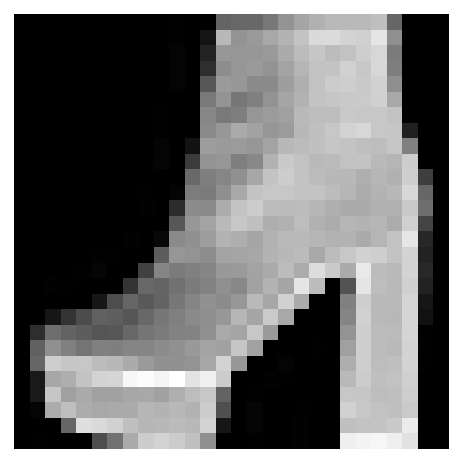

In [116]:
plt.axis("off")
plt.imshow(train_data[643][0].squeeze(0),cmap='gray' )

In [117]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

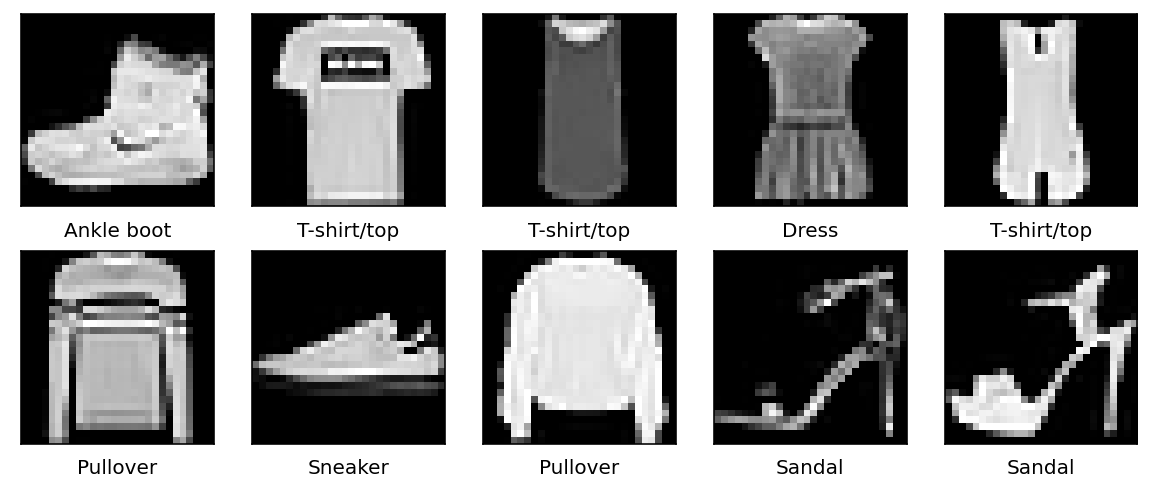

In [118]:
# Checking first 25 images in training data along with the labels

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i][0].squeeze(0),cmap='gray')
    plt.xlabel(class_names[train_data[i][1]])
plt.show()

# 4.Building the model

In [119]:
class Mymodel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
       
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*14*14, 
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.classifier(x)
    return x

In [120]:
torch.manual_seed(42)
cnnmodel = Mymodel(input_shape=1,hidden_units=10,output_shape=10).to(device)
cnnmodel

Mymodel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=10, bias=True)
  )
)

In [121]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


# 5.Start training and testing

In [122]:
from tqdm import tqdm
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn)
        
        #  Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        #  Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    #  Return the filled results at the end of the epochs
    return results

In [123]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5  #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnnmodel.parameters(), lr=0.0001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

model_results = train(cnnmodel,train_dataloader,test_dataloader, optimizer,loss_fn,NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|█████████                                    | 1/5 [00:18<01:12, 18.13s/it]

Epoch: 1 | train_loss: 0.5977 | train_acc: 0.7915 | test_loss: 0.4671 | test_acc: 0.8356


 40%|██████████████████                           | 2/5 [00:36<00:54, 18.13s/it]

Epoch: 2 | train_loss: 0.4263 | train_acc: 0.8487 | test_loss: 0.4334 | test_acc: 0.8458


 60%|███████████████████████████                  | 3/5 [00:54<00:36, 18.13s/it]

Epoch: 3 | train_loss: 0.3878 | train_acc: 0.8635 | test_loss: 0.4029 | test_acc: 0.8601


 80%|████████████████████████████████████         | 4/5 [01:12<00:18, 18.14s/it]

Epoch: 4 | train_loss: 0.3665 | train_acc: 0.8696 | test_loss: 0.3788 | test_acc: 0.8657


100%|█████████████████████████████████████████████| 5/5 [01:30<00:00, 18.15s/it]

Epoch: 5 | train_loss: 0.3495 | train_acc: 0.8760 | test_loss: 0.3641 | test_acc: 0.8711
Total training time: 90.746 seconds


# Plot the loss

In [124]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    # Get the loss values of the results dictionary (training and test)
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # --------------- Complete the following lines --------------
    # Plot loss, please include label, title, and legend in the figure
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss,label='Train loss')   # plot epochs, train_loss
    plt.plot(epochs, test_loss,label='Test loss')   # plot epochs, test_loss
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy,label='Train acc') # plot epochs, train_accuracy, add label
    plt.plot(epochs, test_accuracy,label='Test acc')# plot epochs, test_accuracy, add label
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

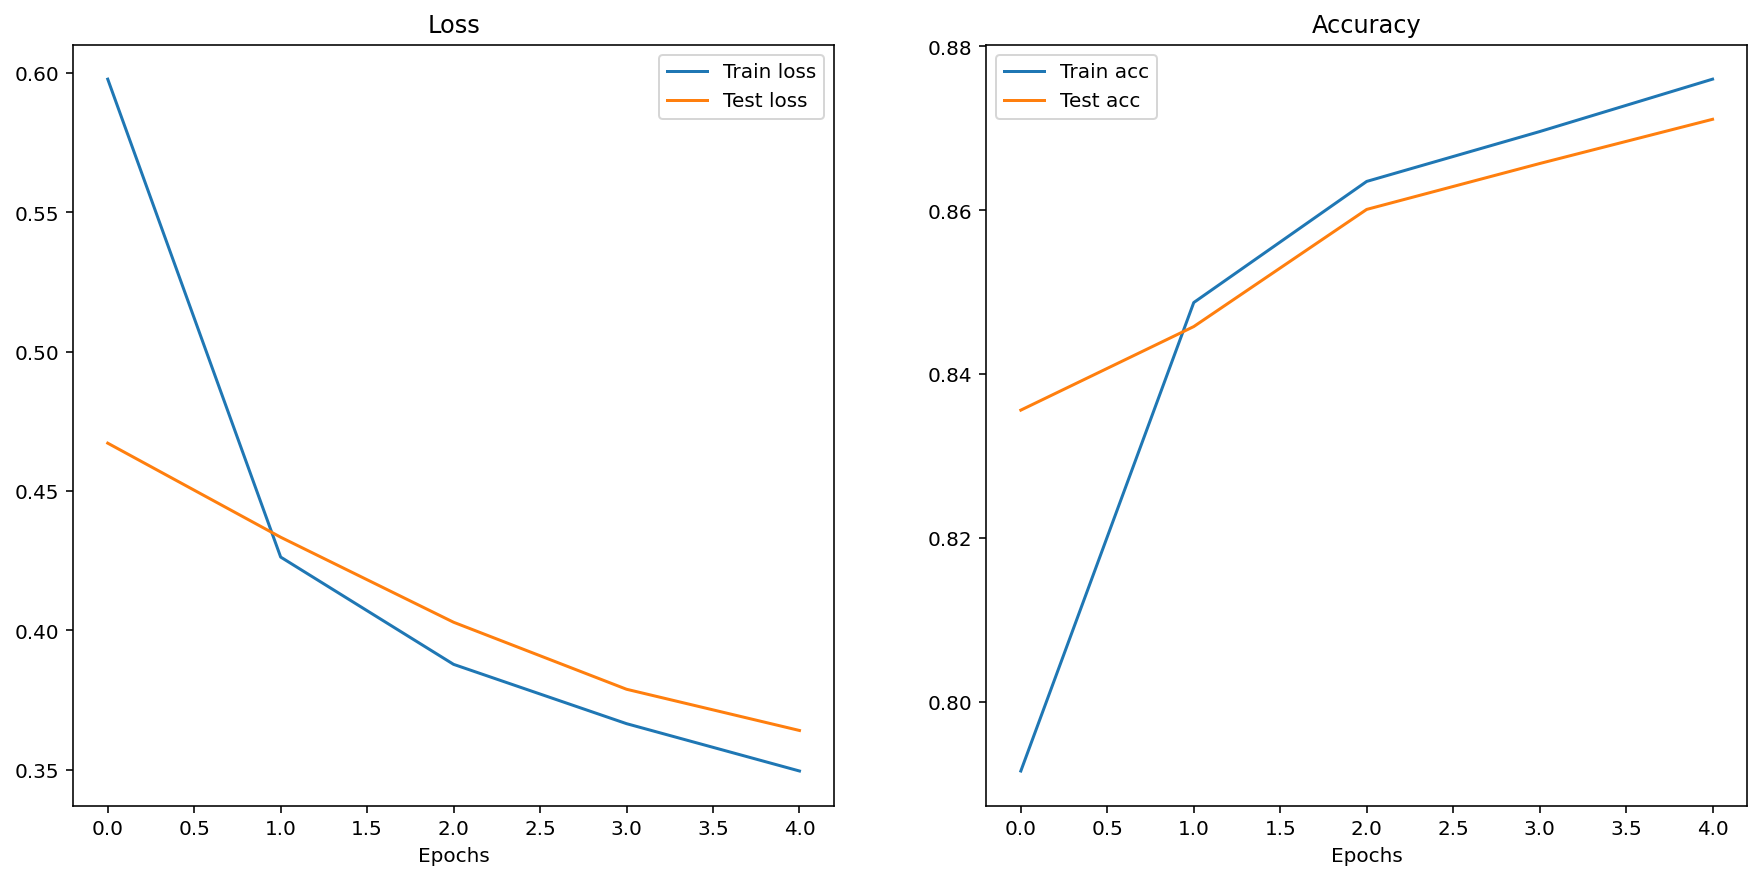

In [125]:
plot_loss_curves(model_results)

# 7.Image recognition tests

In [242]:
# Define view_classify function
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    
    count=1

    for i in range(len(ps)):

      PS = ps[i].data.to("cpu").numpy()
      
      ax1=plt.subplot(4,4,i+count)
      ax1.imshow(img[i].resize_(1, 28, 28).numpy().squeeze())
      ax1.axis('off')
    
      ax2=plt.subplot(4,4,i+count+1)
      ax2.barh(np.arange(10), 0.5*PS)
      ax2.set_aspect(0.1)
      ax2.set_yticks(np.arange(10))
      if version == "MNIST":
          ax2.set_yticklabels(np.arange(10))
      elif version == "Fashion":
          ax2.set_yticklabels(['T-shirt/top',
                              'Trouser',
                              'Pullover',
                              'Dress',
                              'Coat',
                              'Sandal',
                              'Shirt',
                              'Sneaker',
                              'Bag',
                              'Ankle Boot'], size='small');
      ax2.set_title('Class Probability')
      ax2.set_xlim(0, 1.1)
      count+=1
    plt.show()
    plt.tight_layout()

torch.Size([8, 1, 28, 28])

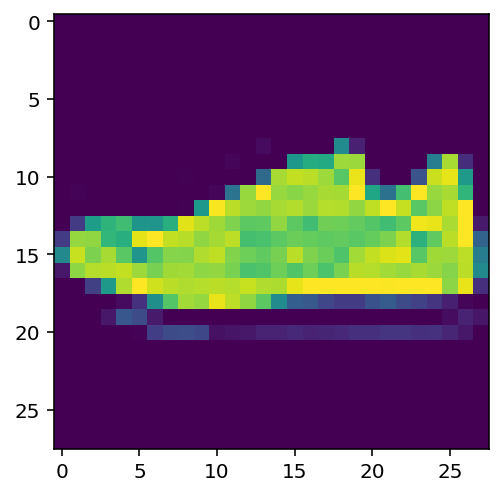

In [243]:
# Examine a sample
dataiter = next(iter(train_dataloader))
images=dataiter[0]
labels=dataiter[1]

#print(type(images))
#print(images.shape)
#print(labels.shape)
plt.imshow(dataiter[0][0].squeeze(0))
dataiter[0].shape

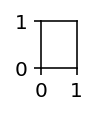

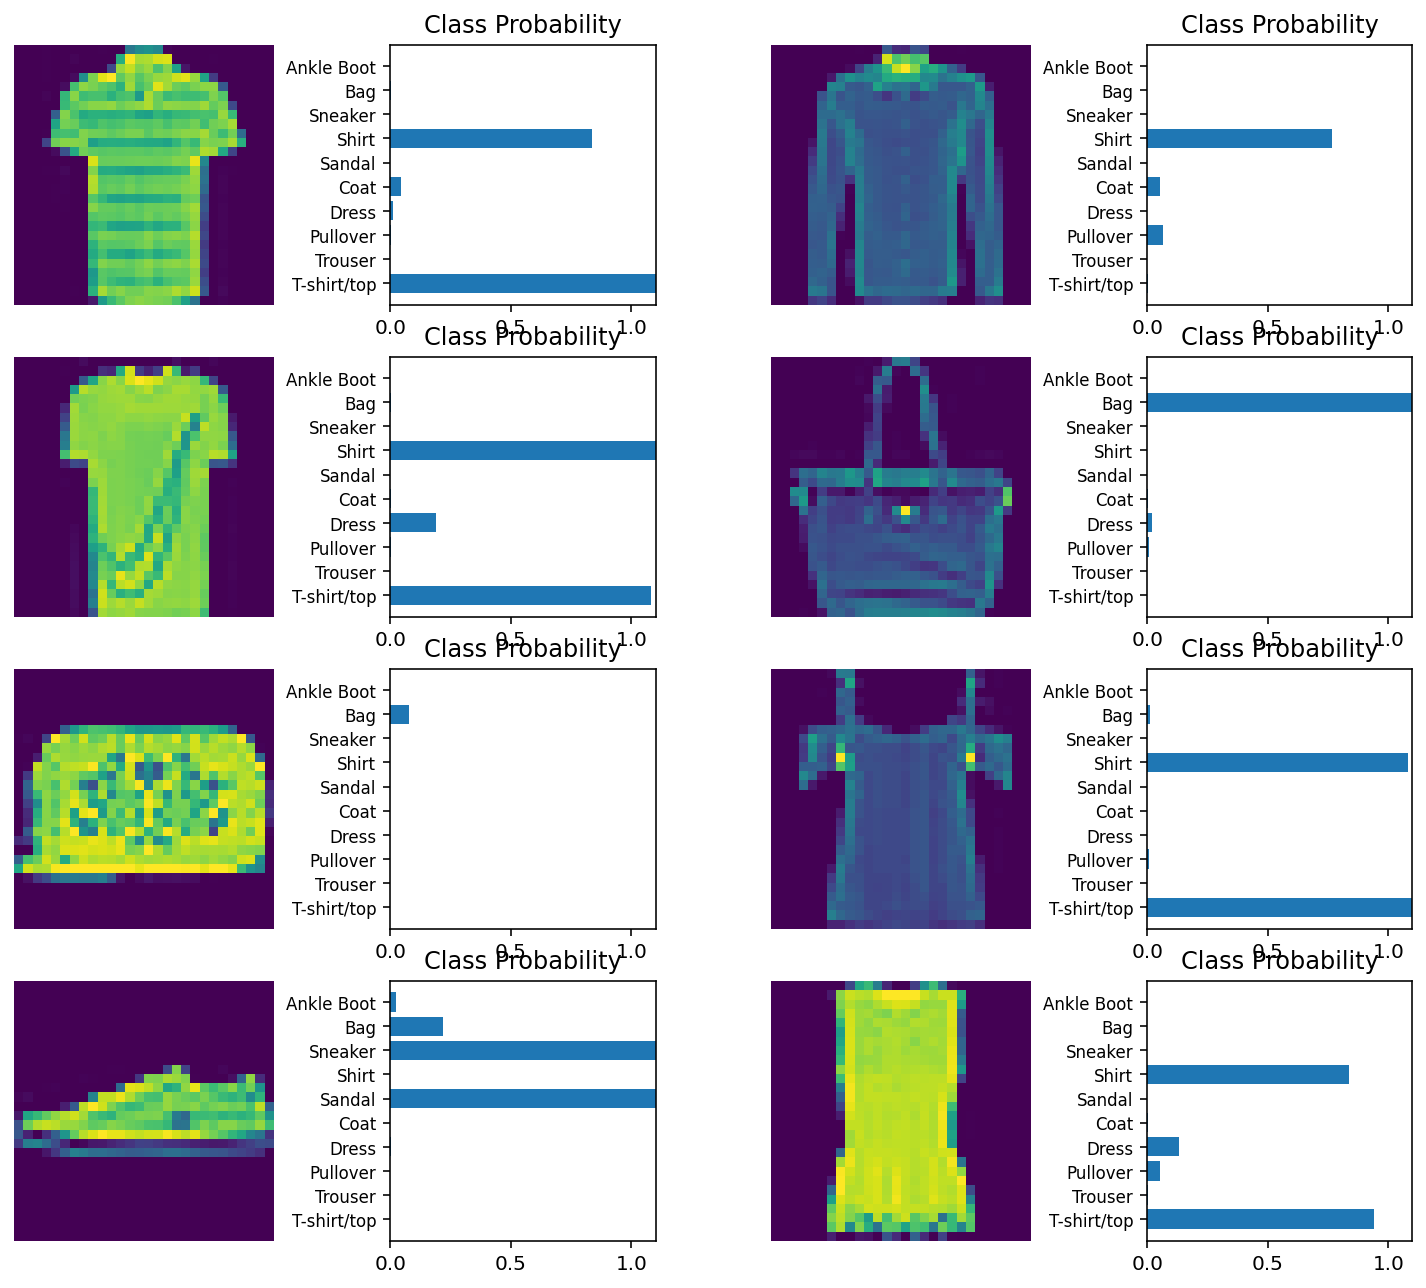

<Figure size 432x288 with 0 Axes>

In [252]:
dataiter = next(iter(train_dataloader))
images=dataiter[0]
labels=dataiter[1]

ps = torch.exp(cnnmodel(images.to(torch.float32).to(device)))
ax1=plt.subplot(8,16,1)
# Plot the image and probabilites
plt.figure(figsize=[13,11])

view_classify(images, ps, version='Fashion')


# 8.Save. the model

In [253]:
print("My model: \n\n", cnnmodel, "\n")
print("The state dict keys: \n\n", cnnmodel.state_dict().keys())

My model: 

 Mymodel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=10, bias=True)
  )
) 

The state dict keys: 

 odict_keys(['conv_block_1.0.weight', 'conv_block_1.0.bias', 'conv_block_1.2.weight', 'conv_block_1.2.bias', 'classifier.1.weight', 'classifier.1.bias'])


In [254]:
torch.save(cnnmodel.state_dict(), 'checkpoint.pth')

# 9.Load the saved model

In [255]:
state_dict = torch.load("checkpoint.pth")
print(state_dict.keys())

odict_keys(['conv_block_1.0.weight', 'conv_block_1.0.bias', 'conv_block_1.2.weight', 'conv_block_1.2.bias', 'classifier.1.weight', 'classifier.1.bias'])


In [256]:
# Load the state dict to the network
cnnmodel.load_state_dict(state_dict)
print(cnnmodel)

Mymodel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=10, bias=True)
  )
)
